In [1]:
# Import libraries
import numpy as np
import pandas as pd
from pandas import datetime

import matplotlib.pyplot as plt # Matlab-style plotting
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

import seaborn as sns # Seaborn visualization
color = sns.color_palette()
sns.set_style('darkgrid')

import warnings # Ignore annoying warning (from sklearn and seaborn)
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) # Limiting floats output to 3 decimal points

# Statistics
from scipy import stats

In [2]:
# Define main path
main_path = '/Users/macbookpro/AnacondaProjects/invent'

In [50]:
# Read data
train = pd.read_csv(main_path + '/data/assignment4.1a.csv')
test = pd.read_csv(main_path + '/data/assignment4.1b.csv')
promotion_dates = pd.read_csv(main_path + '/data/PromotionDates.csv')

# Examine data

In [51]:
# Take a first glance at the data
train.columns

Index(['Date', 'StoreCode', 'ProductCode', 'SalesQuantity'], dtype='object')

In [52]:
# Explore data's shape
train.shape

(1873618, 4)

In [53]:
# Take a look at the head of data
train.head()

,Date,StoreCode,ProductCode,SalesQuantity
0,2015-01-01,8,9,-1
1,2015-01-01,131,9,1
2,2015-01-01,144,9,2
3,2015-01-01,203,9,2
4,2015-01-01,256,9,0


In [54]:
# Convert date columns to datetime
train['Date'] = pd.to_datetime(train['Date'])

We are dealing with time series data so it will probably serve us to extract dates for further analysis. 

In [55]:
# Take a look at the head of data
train.head()

,Date,StoreCode,ProductCode,SalesQuantity
0,2015-01-01,8,9,-1
1,2015-01-01,131,9,1
2,2015-01-01,144,9,2
3,2015-01-01,203,9,2
4,2015-01-01,256,9,0


## Examine promotion_dates and prepare it to be used in train

**promotion_date** has some rows in '%d/%m/%Y' format and some in '%m/%d/%Y' format, so we need to tidy them up

In [56]:
# Create a regularized promotion_dates data frame
promotion_dates = pd.concat(
        [
            promotion_dates['Period'],
            pd.concat(
                [
                    promotion_dates.loc[:3, ['StartDate', 'EndDate']].apply(lambda x: pd.to_datetime(x)), 
                    promotion_dates.loc[4:5, ['StartDate', 'EndDate']].apply(lambda x: pd.to_datetime(x, format='%d/%m/%Y'))
                ]
            )
        ]
    , axis=1    
    )

promotion_dates

,Period,StartDate,EndDate
0,Promo1,2015-02-10,2015-02-17
1,Promo2,2015-03-15,2015-03-22
2,Promo3,2015-05-24,2015-06-01
3,Promo4,2015-06-21,2015-06-28
4,Promo5,2015-09-01,2015-09-06
5,Promo6,2015-11-20,2015-11-27


## Merge promotion periods into train data

In [57]:
# Prepare a cartesian join
cartesian = train.assign(key=1).merge(promotion_dates.assign(key=1), on='key').drop('key', axis=1)

cartesian = cartesian.query('Date >= StartDate and Date <= EndDate')[['Date', 'Period']].drop_duplicates()

In [58]:
cartesian.head()

,Date,Period
3042,2015-02-10,Promo1
3192,2015-02-11,Promo1
3306,2015-02-12,Promo1
3420,2015-02-13,Promo1
3456,2015-02-14,Promo1


In [59]:
cartesian.columns = ['Date', 'OnPromotion']

In [60]:
# Perform the merge operation, take a look at current structure
train = train.merge(cartesian, on='Date', how='left')

train.head()

,Date,StoreCode,ProductCode,SalesQuantity,OnPromotion
0,2015-01-01,8,9,-1,NaN
1,2015-01-01,131,9,1,NaN
2,2015-01-01,144,9,2,NaN
3,2015-01-01,203,9,2,NaN
4,2015-01-01,256,9,0,NaN


In [61]:
# Validate that everything is fine and there are no duplicated rows
train.shape

(1873618, 5)

## Create cartesian table for each Store/Product/Date combination

### Create unique tables

In [62]:
stores = pd.DataFrame(train['StoreCode'].unique(), columns=['StoreCode'])

products = pd.DataFrame(train['ProductCode'].unique(), columns=['ProductCode'])

dates = pd.DataFrame(pd.date_range(start='2015-01-01', end='2015-07-31'), columns=['Date'])

### Merge them to create main cartesian table

In [63]:
cartesian = stores.assign(key=1).merge(products.assign(key=1), on='key').merge(dates.assign(key=1), on='key').drop('key', axis=1)

In [64]:
cartesian.head()

,StoreCode,ProductCode,Date
0,8,9,2015-01-01
1,8,9,2015-01-02
2,8,9,2015-01-03
3,8,9,2015-01-04
4,8,9,2015-01-05


## Fill the gaps in train by merging it with cartesian

In [65]:
train = cartesian.merge(train, on=['Date', 'StoreCode', 'ProductCode'], how='left')

train.head()

,StoreCode,ProductCode,Date,SalesQuantity,OnPromotion
0,8,9,2015-01-01,-1.000,NaN
1,8,9,2015-01-02,nan,NaN
2,8,9,2015-01-03,nan,NaN
3,8,9,2015-01-04,nan,NaN
4,8,9,2015-01-05,nan,NaN


### Fill NAs in SalesQuantity and Period

As there can be seen, after expanding train, there are nan SalesQuantities and Periods, we need to fill them with appropriate values.

In [66]:
train['SalesQuantity'] = train['SalesQuantity'].fillna(0)

In [67]:
train.loc[train['SalesQuantity'] < 0, 'SalesQuantity'] = 0

In [68]:
train['OnPromotion'] = train['OnPromotion'].fillna(0)

In [69]:
train.loc[train['OnPromotion'] != 0, 'OnPromotion'] = 1

In [70]:
train.head()

,StoreCode,ProductCode,Date,SalesQuantity,OnPromotion
0,8,9,2015-01-01,0.000,0
1,8,9,2015-01-02,0.000,0
2,8,9,2015-01-03,0.000,0
3,8,9,2015-01-04,0.000,0
4,8,9,2015-01-05,0.000,0


## Extract date related columns

In [71]:
# Date related column extraction
train['DayOfWeek'] = train['Date'].dt.dayofweek
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train['WeekOfYear'] = train['Date'].dt.weekofyear
train['IsWeekend'] = (train['Date'].dt.dayofweek // 5 == 1).astype(int)

In [72]:
train.head()

,StoreCode,ProductCode,Date,SalesQuantity,OnPromotion,DayOfWeek,Month,Day,WeekOfYear,IsWeekend
0,8,9,2015-01-01,0.000,0,3,1,1,1,0
1,8,9,2015-01-02,0.000,0,4,1,2,1,0
2,8,9,2015-01-03,0.000,0,5,1,3,1,1
3,8,9,2015-01-04,0.000,0,6,1,4,1,1
4,8,9,2015-01-05,0.000,0,0,1,5,2,0


## Extract dummy variables for promotion periods

In [73]:
# Get dummies for period column and create columns for future promotions
#train = pd.get_dummies(train)

#train['Period_Promo5'] = 0
#train['Period_Promo6'] = 0

In [74]:
#train.head()

In [75]:
# Take a look at descriptive statistics
train.describe(include='all')

,StoreCode,ProductCode,Date,SalesQuantity,OnPromotion,DayOfWeek,Month,Day,WeekOfYear,IsWeekend
count,22849360.000,22849360.000,22849360,22849360.000,22849360.000,22849360.000,22849360.000,22849360.000,22849360.000,22849360.000
unique,nan,nan,212,nan,2.000,nan,nan,nan,nan,nan
top,nan,nan,2015-04-18 00:00:00,nan,0.000,nan,nan,nan,nan,nan
freq,nan,nan,107780,nan,22538437.000,nan,nan,nan,nan,nan
first,nan,nan,2015-01-01 00:00:00,nan,nan,nan,nan,nan,nan,nan
last,nan,nan,2015-07-31 00:00:00,nan,nan,nan,nan,nan,nan,nan
mean,170.500,159.000,NaN,0.185,nan,3.005,4.019,15.660,16.071,0.283
std,98.149,91.510,NaN,1.564,nan,1.992,2.005,8.767,8.751,0.450
min,1.000,1.000,NaN,0.000,nan,0.000,1.000,1.000,1.000,0.000
25%,85.750,80.000,NaN,0.000,nan,1.000,2.000,8.000,8.750,0.000


In [76]:
# Train's shape
train.shape

(22849360, 10)

# -> Question A - a / A - b

# Store and Product Clustering

## Product-Store Performance

### Compute average weekly sales for each Product - Store 

In [77]:
product_sum_weekly_sales = train[train['OnPromotion'] == 0].groupby(['StoreCode', 'ProductCode', 'WeekOfYear'], as_index=False)['SalesQuantity'].sum()
product_avg_weekly_sales = product_sum_weekly_sales.groupby(['StoreCode', 'ProductCode'], as_index=False)['SalesQuantity'].mean()

product_avg_weekly_sales.head()

,StoreCode,ProductCode,SalesQuantity
0,1,1,0.645
1,1,2,0.484
2,1,3,0.935
3,1,4,0.419
4,1,5,0.355


### Look at the distribution of 'SalesQuantity'

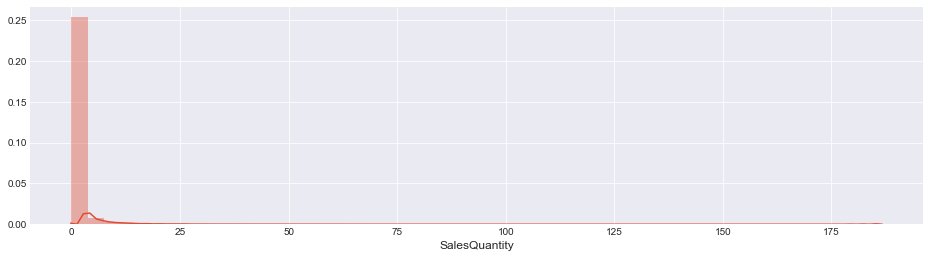

In [78]:
plt.figure(figsize=(16,4))
sns.distplot(product_avg_weekly_sales['SalesQuantity'])

### Compute cumulative sales and divide data into clusters

- Divide product-stores by their standings, **label first 33% of the data as 'Fast', 33% to 66% as 'Medium' and the rest as 'Slow'**

In [79]:
# First sort products by sales
product_avg_weekly_sales = product_avg_weekly_sales.sort_values(by=['SalesQuantity'], ascending=False)

# Compute cumulative sum and percentage
product_avg_weekly_sales['CumulativeSum'] = product_avg_weekly_sales.SalesQuantity.cumsum()
product_avg_weekly_sales['CumulativePercentage'] = 100*product_avg_weekly_sales.CumulativeSum/product_avg_weekly_sales.SalesQuantity.sum()

# Take a look at data
product_avg_weekly_sales.head(10)

,StoreCode,ProductCode,SalesQuantity,CumulativeSum,CumulativePercentage
36939,117,168,186.536,186.536,0.168
19504,62,168,170.552,357.087,0.322
30966,98,218,165.034,522.122,0.471
75346,238,218,157.966,680.087,0.614
104827,331,218,144.300,824.387,0.744
88927,281,168,137.700,962.087,0.868
96268,304,218,124.900,1086.987,0.981
62666,198,218,116.586,1203.574,1.086
95267,301,168,115.517,1319.091,1.191
87392,276,218,115.483,1434.574,1.295


In [80]:
# Label data as :
# First 33% of the data as 'Fast', 33% to 66% as 'Medium' and the rest as 'Slow'
product_avg_weekly_sales['ProductCluster'] = 'Slow'
product_avg_weekly_sales.loc[product_avg_weekly_sales['CumulativePercentage'] < 33, 'ProductCluster'] = 'Fast'
product_avg_weekly_sales.loc[(product_avg_weekly_sales['CumulativePercentage'] < 66) & (product_avg_weekly_sales['CumulativePercentage'] >= 33), 'ProductCluster'] = 'Medium'

# Final status of the data
product_avg_weekly_sales.head(10)

,StoreCode,ProductCode,SalesQuantity,CumulativeSum,CumulativePercentage,ProductCluster
36939,117,168,186.536,186.536,0.168,Fast
19504,62,168,170.552,357.087,0.322,Fast
30966,98,218,165.034,522.122,0.471,Fast
75346,238,218,157.966,680.087,0.614,Fast
104827,331,218,144.300,824.387,0.744,Fast
88927,281,168,137.700,962.087,0.868,Fast
96268,304,218,124.900,1086.987,0.981,Fast
62666,198,218,116.586,1203.574,1.086,Fast
95267,301,168,115.517,1319.091,1.191,Fast
87392,276,218,115.483,1434.574,1.295,Fast


## Analyze product clusters

In [81]:
product_avg_weekly_sales.groupby('ProductCluster')['SalesQuantity'].describe()

,count,mean,std,min,25%,50%,75%,max
ProductCluster,,,,,,,,
Fast,1493.000,24.488,18.096,11.548,13.935,18.419,27.161,186.536
Medium,7472.000,4.894,2.242,2.516,3.097,4.129,6.065,11.548
Slow,98815.000,0.381,0.531,0.000,0.000,0.129,0.548,2.516


** Things to note : **
    - Only 1493 items are making up the 33% of the total sales 
    - Only 7472 items are making up the 66% of the total sales 
    - We have labeled 98815 products as 'Slow'


## Sales distribution by product cluster 

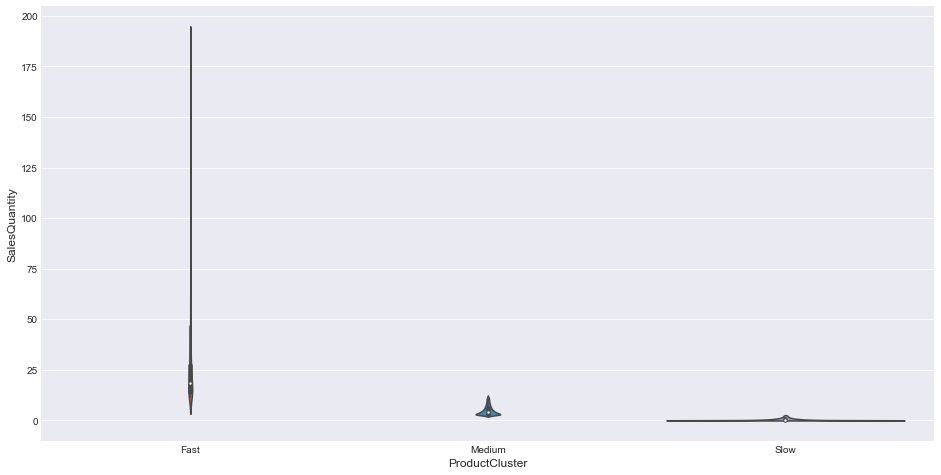

In [82]:
plt.figure(figsize=(16,8))
sns.violinplot(data=product_avg_weekly_sales, x='ProductCluster', y='SalesQuantity')

## Store Performance (Execute the same procedures for store data)

### Compute average weekly sales for each Store

In [83]:
store_sum_weekly_sales = train[train['OnPromotion'] == 0].groupby(['StoreCode', 'WeekOfYear'], as_index=False)['SalesQuantity'].sum()
store_avg_weekly_sales = store_sum_weekly_sales.groupby(['StoreCode'], as_index=False)['SalesQuantity'].mean()

store_avg_weekly_sales.head()

,StoreCode,SalesQuantity
0,1,335.774
1,2,1095.452
2,3,220.871
3,4,340.387
4,5,275.839


### Look at the distribution of 'SalesQuantity'

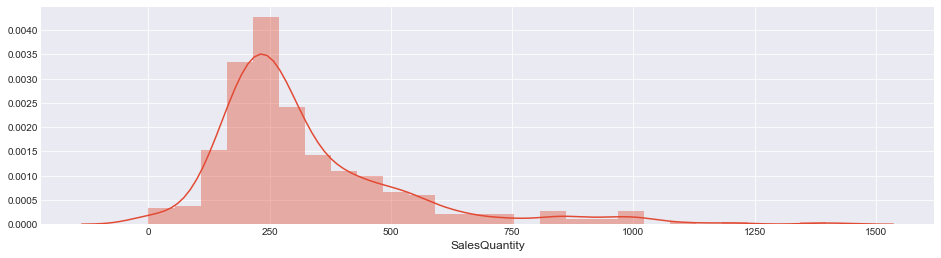

In [84]:
plt.figure(figsize=(16,4))
sns.distplot(store_avg_weekly_sales['SalesQuantity'])

### Compute cumulative sales and divide data into clusters

- Divide stores by their standings, **label first 33% of the data as 'Fast', 33% to 66% as 'Medium' and the rest as 'Slow'**

In [85]:
# First sort products by sales
store_avg_weekly_sales = store_avg_weekly_sales.sort_values(by=['SalesQuantity'], ascending=False)

# Compute cumulative sum and percentage
store_avg_weekly_sales['CumulativeSum'] = store_avg_weekly_sales.SalesQuantity.cumsum()
store_avg_weekly_sales['CumulativePercentage'] = 100*store_avg_weekly_sales.CumulativeSum/store_avg_weekly_sales.SalesQuantity.sum()

# Take a look at data
store_avg_weekly_sales.head(10)

,StoreCode,SalesQuantity,CumulativeSum,CumulativePercentage
330,331,1398.097,1398.097,1.269
275,276,1200.419,2598.516,2.358
1,2,1095.452,3693.968,3.352
280,281,1019.129,4713.097,4.277
97,98,1016.903,5730.000,5.199
61,62,1008.452,6738.452,6.114
300,301,981.968,7720.419,7.005
59,60,980.677,8701.097,7.895
98,99,948.097,9649.194,8.756
116,117,934.903,10584.097,9.604


In [86]:
# Label data as :
# First 33% of the data as 'Fast', 33% to 66% as 'Medium' and the rest as 'Slow'
store_avg_weekly_sales['StoreCluster'] = 'Slow'
store_avg_weekly_sales.loc[store_avg_weekly_sales['CumulativePercentage'] < 33, 'StoreCluster'] = 'Fast'
store_avg_weekly_sales.loc[(store_avg_weekly_sales['CumulativePercentage'] < 66) & (store_avg_weekly_sales['CumulativePercentage'] >= 33), 'StoreCluster'] = 'Medium'

# Final status of the data
store_avg_weekly_sales.head(10)

,StoreCode,SalesQuantity,CumulativeSum,CumulativePercentage,StoreCluster
330,331,1398.097,1398.097,1.269,Fast
275,276,1200.419,2598.516,2.358,Fast
1,2,1095.452,3693.968,3.352,Fast
280,281,1019.129,4713.097,4.277,Fast
97,98,1016.903,5730.000,5.199,Fast
61,62,1008.452,6738.452,6.114,Fast
300,301,981.968,7720.419,7.005,Fast
59,60,980.677,8701.097,7.895,Fast
98,99,948.097,9649.194,8.756,Fast
116,117,934.903,10584.097,9.604,Fast


## Analyze store clusters

In [87]:
store_avg_weekly_sales.groupby('StoreCluster')['SalesQuantity'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreCluster,,,,,,,,
Fast,51.000,712.538,213.373,498.613,541.823,628.065,854.339,1398.097
Medium,100.000,361.193,60.814,280.516,310.726,344.226,406.589,493.290
Slow,189.000,199.722,58.188,0.000,169.129,209.226,244.290,279.226


** Things to note : **
    - 51 stores are making up the 33% of the total sales 
    - 100 stores are making up the 66% of the total sales 
    - We have labeled 189 stores as 'Slow'


## Sales distribution by store clusters

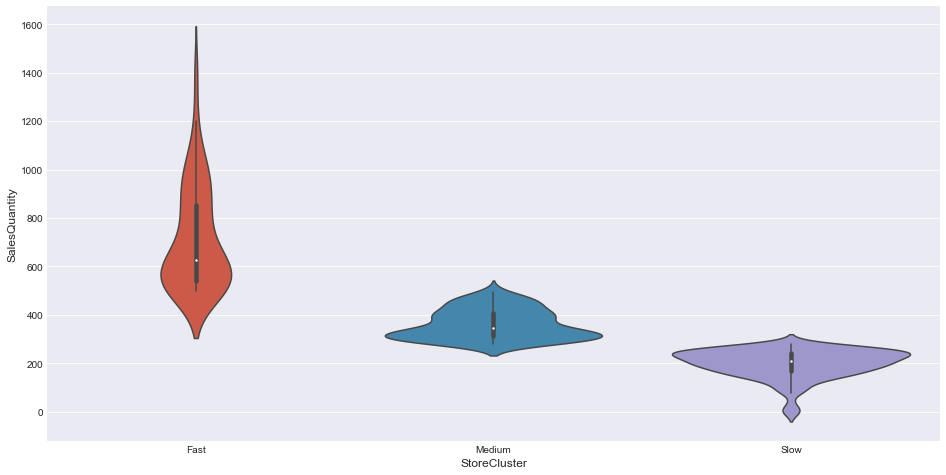

In [88]:
plt.figure(figsize=(16,8))
sns.violinplot(data=store_avg_weekly_sales, x='StoreCluster', y='SalesQuantity')

## Merge cluster labels to `train`

In [89]:
# Merge product cluster labels
train = train.merge(product_avg_weekly_sales[['StoreCode', 'ProductCode', 'ProductCluster']], 
            on=['StoreCode', 'ProductCode'], 
            how='left')

# Merge store cluster labels
train = train.merge(store_avg_weekly_sales[['StoreCode', 'StoreCluster']], 
            on='StoreCode', 
            how='left')

In [90]:
train.head()

,StoreCode,ProductCode,Date,SalesQuantity,OnPromotion,DayOfWeek,Month,Day,WeekOfYear,IsWeekend,ProductCluster,StoreCluster
0,8,9,2015-01-01,0.000,0,3,1,1,1,0,Slow,Slow
1,8,9,2015-01-02,0.000,0,4,1,2,1,0,Slow,Slow
2,8,9,2015-01-03,0.000,0,5,1,3,1,1,Slow,Slow
3,8,9,2015-01-04,0.000,0,6,1,4,1,1,Slow,Slow
4,8,9,2015-01-05,0.000,0,0,1,5,2,0,Slow,Slow


### Get dummies for cluster columns

In [91]:
# For cluster columns
train = pd.get_dummies(data=train, columns=['ProductCluster', 'StoreCluster'])

In [92]:
train.head()

,StoreCode,ProductCode,Date,SalesQuantity,OnPromotion,DayOfWeek,Month,Day,WeekOfYear,IsWeekend,ProductCluster_Fast,ProductCluster_Medium,ProductCluster_Slow,StoreCluster_Fast,StoreCluster_Medium,StoreCluster_Slow
0,8,9,2015-01-01,0.000,0,3,1,1,1,0,0,0,1,0,0,1
1,8,9,2015-01-02,0.000,0,4,1,2,1,0,0,0,1,0,0,1
2,8,9,2015-01-03,0.000,0,5,1,3,1,1,0,0,1,0,0,1
3,8,9,2015-01-04,0.000,0,6,1,4,1,1,0,0,1,0,0,1
4,8,9,2015-01-05,0.000,0,0,1,5,2,0,0,0,1,0,0,1


# -> Question A - c

## Analyze biggest product reactions to promotions

In [93]:
# Find mean of sales on promotion and off promotion for each product
product_prom_changes = train[['ProductCode', 'OnPromotion', 'SalesQuantity']].groupby(['ProductCode', 'OnPromotion'])['SalesQuantity'].mean()

# Get on/off promotion value to a column
product_prom_changes = product_prom_changes.unstack().fillna(0)

# View data
product_prom_changes.head(10)

OnPromotion,0,1
ProductCode,,
1,0.133,2.424
2,0.100,2.351
3,0.073,2.002
4,0.089,2.178
5,0.107,2.366
6,0.017,0.549
7,0.079,1.752
8,0.001,1.200
9,0.010,0.414


In [94]:
# Calculate change
product_prom_changes['Change'] = (product_prom_changes[1] - product_prom_changes[0]) / product_prom_changes[0]

# Sort the producs and view top 10 changes
product_prom_changes = product_prom_changes[np.isfinite(product_prom_changes['Change'])].sort_values(by=['Change'], ascending=False).head(10)

product_prom_changes

OnPromotion,0,1,Change
ProductCode,,,
163,0.000,1.000,72077.000
291,0.000,1.500,36038.000
73,0.000,1.000,18018.750
230,0.000,1.000,12012.000
13,0.000,0.500,6005.167
34,0.000,1.200,4323.500
229,0.000,1.000,3792.316
12,0.000,0.250,3602.800
55,0.000,0.333,3431.238


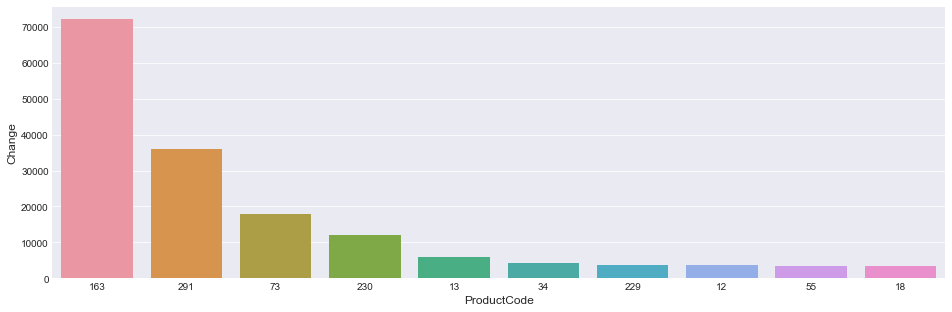

In [95]:
order = list(product_prom_changes.index)

plt.figure(figsize=(16,5))
sns.barplot(x='ProductCode', y='Change', order=order, data=product_prom_changes.reset_index())

# -> Question A - d

## Analyze biggest store reactions to promotions

In [96]:
# Find sum of sales on promotion and off promotion for each store
store_prom_changes = train[['StoreCode', 'OnPromotion', 'SalesQuantity']].groupby(['StoreCode', 'OnPromotion'])['SalesQuantity'].mean()

# Get on/off promotion value to a column
store_prom_changes = store_prom_changes.unstack().fillna(0)

# View data
store_prom_changes.head(10)

OnPromotion,0,1
StoreCode,,
1,0.157,2.354
2,0.521,3.706
3,0.103,1.874
4,0.159,2.849
5,0.129,1.771
6,0.204,2.697
7,0.250,2.907
8,0.121,2.426
9,0.239,3.389


In [97]:
# Calculate change
store_prom_changes['Change'] = (store_prom_changes[1] - store_prom_changes[0]) / store_prom_changes[0]

# Sort the stores and view top 10 changes
store_prom_changes = store_prom_changes[np.isfinite(store_prom_changes['Change'])].sort_values(by=['Change'], ascending=False).head(10)

store_prom_changes

OnPromotion,0,1,Change
StoreCode,,,
29,0.008,1.286,162.527
92,0.040,4.761,118.678
143,0.075,2.738,35.633
105,0.036,1.267,34.492
139,0.047,1.664,34.280
166,0.042,1.416,32.931
102,0.064,2.142,32.687
230,0.040,1.341,32.663
164,0.041,1.310,31.190


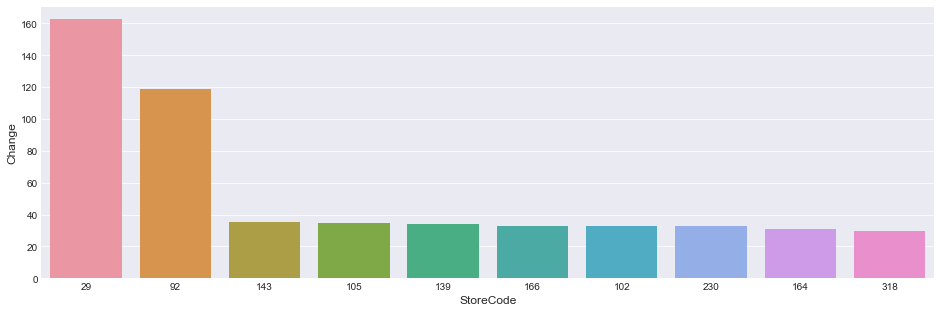

In [98]:
order = list(store_prom_changes.index)

plt.figure(figsize=(16,5))
sns.barplot(x='StoreCode', y='Change', order=order, data=store_prom_changes.reset_index())

# -> Question A - f / A- g

## Looking at significant differences between fast and slow products/stores

### Calculate the T-test for the means of two independent samples

The t score is a ratio between the difference between two groups and the difference within the groups. The larger the t score, the more difference there is between groups. The smaller the t score, the more similarity there is between groups.

We can use this test, if we observe two independent samples from the same or different population, e.g. exam scores of boys and girls or of two ethnic groups. The test measures whether the average (expected) value differs significantly across samples. If we observe a large p-value, for example larger than 0.05 or 0.1, then we cannot reject the null hypothesis of identical average scores. If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages.

- So we will use this test to see whether promotion periods have a significant impact on products and stores. Then we will compare the t-scores.

### Promotion effect on slow products

In [99]:
stats.ttest_ind(train.loc[(train['ProductCluster_Slow'] == 1) & (train['OnPromotion'] == 1), 'SalesQuantity'], 
                      train.loc[(train['ProductCluster_Slow'] == 1) & (train['OnPromotion'] == 0), 'SalesQuantity'])

Ttest_indResult(statistic=1003.9301492048306, pvalue=0.0)

### Promotion effect on fast products

In [100]:
stats.ttest_ind(train.loc[(train['ProductCluster_Fast'] == 1) & (train['OnPromotion'] == 1), 'SalesQuantity'], 
                      train.loc[(train['ProductCluster_Fast'] == 1) & (train['OnPromotion'] == 0), 'SalesQuantity'])

Ttest_indResult(statistic=98.956431596004094, pvalue=0.0)

### Promotion effect on slow stores

In [101]:
stats.ttest_ind(train.loc[(train['StoreCluster_Slow'] == 1) & (train['OnPromotion'] == 1), 'SalesQuantity'], 
                      train.loc[(train['StoreCluster_Slow'] == 1) & (train['OnPromotion'] == 0), 'SalesQuantity'])

Ttest_indResult(statistic=673.22514691704339, pvalue=0.0)

### Promotion effect on fast stores

In [102]:
stats.ttest_ind(train.loc[(train['StoreCluster_Fast'] == 1) & (train['OnPromotion'] == 1), 'SalesQuantity'], 
                      train.loc[(train['StoreCluster_Fast'] == 1) & (train['OnPromotion'] == 0), 'SalesQuantity'])

Ttest_indResult(statistic=335.50101796784571, pvalue=0.0)

### Results : 

- All p-values are lower than 0.05 so we can say that promotions have a significant effect on products and stores.

- We can say that promotions have a greater impact on **slow products** then fast products. And also the same situation applies for stores.

- This might be caused because fast products are already selling much but people are buying unappealing products when they encounter with a promotion.

## Calculate lag sales for 7, 14, 21 and 30 days

It has been considered as an important feature on time series data to use lags of the target variable.

Lag columns : 

- LagOne = 7
- LagTwo = 14
- LagThree = 21
- LagFour = 30


In [105]:
# Calculate lag sales total for various windows

groupby = train.groupby(['StoreCode', 'ProductCode'])['SalesQuantity']

train['LagOne'] = groupby.rolling(window=7).sum().reset_index()['SalesQuantity']
train['LagTwo'] = groupby.rolling(window=14).sum().reset_index()['SalesQuantity']
train['LagThree'] = groupby.rolling(window=21).sum().reset_index()['SalesQuantity']
train['LagFour'] = groupby.rolling(window=30).sum().reset_index()['SalesQuantity']

In [ ]:
train = train.fillna(0)

In [108]:
train.head(10)

,StoreCode,ProductCode,Date,SalesQuantity,OnPromotion,DayOfWeek,Month,Day,WeekOfYear,IsWeekend,ProductCluster_Fast,ProductCluster_Medium,ProductCluster_Slow,StoreCluster_Fast,StoreCluster_Medium,StoreCluster_Slow,LagOne,LagTwo,LagThree,LagFour
0,8,9,2015-01-01,0.000,0,3,1,1,1,0,0,0,1,0,0,1,0.000,0.000,0.000,0.000
1,8,9,2015-01-02,0.000,0,4,1,2,1,0,0,0,1,0,0,1,0.000,0.000,0.000,0.000
2,8,9,2015-01-03,0.000,0,5,1,3,1,1,0,0,1,0,0,1,0.000,0.000,0.000,0.000
3,8,9,2015-01-04,0.000,0,6,1,4,1,1,0,0,1,0,0,1,0.000,0.000,0.000,0.000
4,8,9,2015-01-05,0.000,0,0,1,5,2,0,0,0,1,0,0,1,0.000,0.000,0.000,0.000
5,8,9,2015-01-06,0.000,0,1,1,6,2,0,0,0,1,0,0,1,0.000,0.000,0.000,0.000
6,8,9,2015-01-07,0.000,0,2,1,7,2,0,0,0,1,0,0,1,4.000,0.000,0.000,0.000
7,8,9,2015-01-08,0.000,0,3,1,8,2,0,0,0,1,0,0,1,4.000,0.000,0.000,0.000
8,8,9,2015-01-09,0.000,0,4,1,9,2,0,0,0,1,0,0,1,4.000,0.000,0.000,0.000
9,8,9,2015-01-10,0.000,0,5,1,10,2,1,0,0,1,0,0,1,4.000,0.000,0.000,0.000


## Extract features for test data

In [110]:
test['Date'] = pd.to_datetime(test['Date'])
test['OnPromotion'] = 1
test['DayOfWeek'] = test['Date'].dt.dayofweek
test['Month'] = test['Date'].dt.month
test['Day'] = test['Date'].dt.day
test['WeekOfYear'] = test['Date'].dt.weekofyear
test['IsWeekend'] = (test['Date'].dt.dayofweek // 5 == 1).astype(int)

test = test.merge(product_avg_weekly_sales[['StoreCode', 'ProductCode', 'ProductCluster']], 
            on=['StoreCode', 'ProductCode'], 
            how='left')

# Merge store cluster labels
test = test.merge(store_avg_weekly_sales[['StoreCode', 'StoreCluster']], 
            on='StoreCode', 
            how='left')

In [111]:
test = pd.get_dummies(data=test, columns=['ProductCluster', 'StoreCluster'])

In [117]:
groupby = test.groupby(['StoreCode', 'ProductCode'])['SalesQuantity']

test['LagOne'] = groupby.rolling(window=7).sum().reset_index()['SalesQuantity']
test['LagTwo'] = groupby.rolling(window=14).sum().reset_index()['SalesQuantity']
test['LagThree'] = groupby.rolling(window=21).sum().reset_index()['SalesQuantity']
test['LagFour'] = groupby.rolling(window=30).sum().reset_index()['SalesQuantity']

In [119]:
test = test.fillna(0)

In [120]:
test.head(10)

,Date,StoreCode,ProductCode,SalesQuantity,OnPromotion,DayOfWeek,Month,Day,WeekOfYear,IsWeekend,ProductCluster_Fast,ProductCluster_Medium,ProductCluster_Slow,StoreCluster_Fast,StoreCluster_Medium,StoreCluster_Slow,LagOne,LagTwo,LagThree,LagFour
0,2015-08-01,2,9,1,1,5,8,1,31,1,0,0,1,1,0,0,0.000,0.000,0.000,0.000
1,2015-08-01,7,9,1,1,5,8,1,31,1,0,0,1,1,0,0,0.000,0.000,0.000,0.000
2,2015-08-01,62,9,1,1,5,8,1,31,1,0,0,1,1,0,0,0.000,0.000,0.000,0.000
3,2015-08-01,181,9,1,1,5,8,1,31,1,0,0,1,0,1,0,0.000,0.000,0.000,0.000
4,2015-08-01,6,20,1,1,5,8,1,31,1,0,0,1,0,1,0,0.000,0.000,0.000,0.000
5,2015-08-01,7,20,1,1,5,8,1,31,1,0,0,1,1,0,0,0.000,0.000,0.000,0.000
6,2015-08-01,35,20,1,1,5,8,1,31,1,0,0,1,0,1,0,0.000,0.000,0.000,0.000
7,2015-08-01,128,20,2,1,5,8,1,31,1,0,0,1,0,0,1,0.000,0.000,0.000,0.000
8,2015-08-01,159,20,2,1,5,8,1,31,1,0,0,1,0,1,0,0.000,0.000,0.000,0.000
9,2015-08-01,231,20,3,1,5,8,1,31,1,0,1,0,0,0,1,0.000,0.000,0.000,0.000


# -> Question B

## Modelling

In [121]:
ids = train[['StoreCode', 'ProductCode', 'Date']]

In [122]:
train_labels = np.array(train['SalesQuantity'])
test_labels = np.array(test['SalesQuantity'])

In [123]:
train_features = train.drop(['StoreCode', 'ProductCode', 'Date', 'SalesQuantity'], axis = 1)
test_features = test.drop(['StoreCode', 'ProductCode', 'Date', 'SalesQuantity'], axis = 1)

In [124]:
train_features = train_features.fillna(0)
test_features = test_features.fillna(0)

In [125]:
feature_list = list(train_features.columns)

In [126]:
train_features = np.array(train_features)
test_features = np.array(test_features)

In [127]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (22849360, 16)
Training Labels Shape: (22849360,)
Testing Features Shape: (1028121, 16)
Testing Labels Shape: (1028121,)


In [128]:
from sklearn.metrics import mean_squared_error

# The baseline predictions are the last weeks sales
baseline_preds = test_features[:, feature_list.index('LagOne')]

# Baseline errors, and display average baseline error
baseline_errors = np.sqrt(mean_squared_error(test_labels, baseline_preds))

print('Average baseline error: ', round(baseline_errors, 2))

Average baseline error:  20.5


In [129]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 10 decision trees
rf = RandomForestRegressor(n_estimators = 10, max_depth = 3, random_state = 42)

# Train the model on training data
rf.fit(train_features, train_labels);

In [130]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = np.sqrt(mean_squared_error(test_labels, predictions))

# Print out the root mean squared error (rmse)
print('Root Mean Squared Error:', round(errors, 2))

Root Mean Squared Error: 4.48


In [131]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: ProductCluster_Fast  Importance: 0.66
Variable: OnPromotion          Importance: 0.2
Variable: ProductCluster_Slow  Importance: 0.1
Variable: StoreCluster_Fast    Importance: 0.02
Variable: ProductCluster_Medium Importance: 0.01
Variable: LagFour              Importance: 0.01
Variable: DayOfWeek            Importance: 0.0
Variable: Month                Importance: 0.0
Variable: Day                  Importance: 0.0
Variable: WeekOfYear           Importance: 0.0
Variable: IsWeekend            Importance: 0.0
Variable: StoreCluster_Medium  Importance: 0.0
Variable: StoreCluster_Slow    Importance: 0.0
Variable: LagOne               Importance: 0.0
Variable: LagTwo               Importance: 0.0
Variable: LagThree             Importance: 0.0


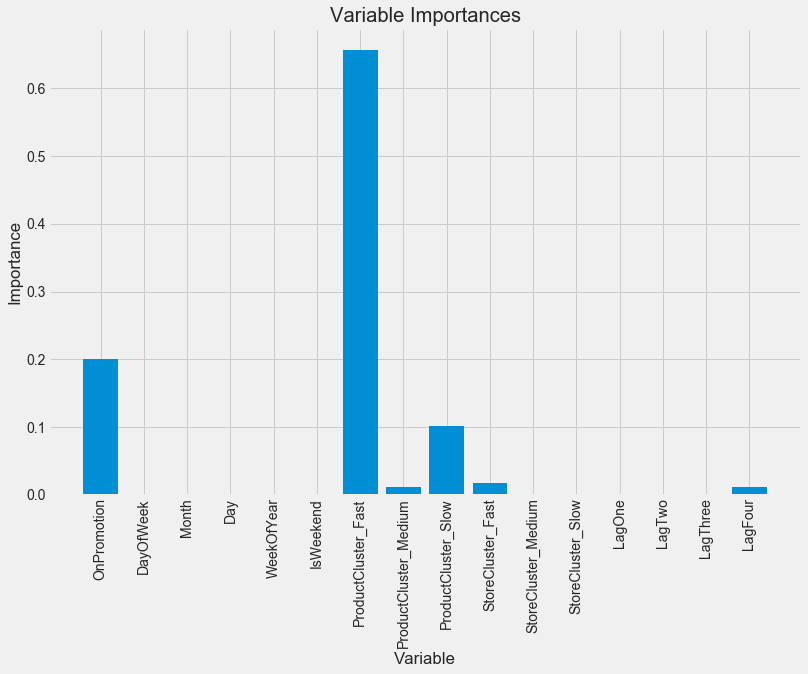

In [132]:
# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

# -> Question A-e

**The biggest effect explaining sales change during promotions** is product cluster. If the product is a selling one, then the chance of higher sales is increasing.

# Results : 

- I have used **root squared mean error(RMSE)** over other loss functions like mean absolute error(MAE) because since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors. This means the RMSE should be more useful when large errors are particularly undesirable. 


- My model have beaten the baseline benchmark which was predicting sales with last week's total sales. My model has a Root Mean Squared Error of **4.48 while baseline was 20.5**


- **Things that could cause to bad fit are : **
    - Lack of information (mentioned at extra datasets part)
    - Unstable data
    - Lack of hyperparameter tuning
    - Lack of more feature engineering


- **Things that I would change at step 1 :**
    - I would change the way I clustered products and stores with the help of univariate analysis but did it absolutely intuitively.
    - I would optimize the code that calculates lag sales for product/stores.
    - I would generate more explanatory graphs about data.
    - I would want to try a time-series approach rather than regression.
   
   
- **Extra datasets I would want to use for this task :** 
    - Stores data -> Location(lat/lon), City, State etc.
    - Products data -> Product family, class, type
    - Basket data -> Which products are sold together?
   
